# Imports

In [1]:
# data generation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy.stats import gamma, norm, expon
from ipywidgets import interact
from ml import *

# modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from datetime import date, datetime
from ipywidgets import interact, interactive, widgets, fixed, Dropdown
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import r2_score
from scipy.stats import mode
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import multiprocessing as mp
import joblib
from ml import *

# Generate Data

In [15]:
customers = {'Slugworth': {'std': 100, 'growth': 0, 'shape': 'none'}, 
             'Perk-a-Cola': {'std': 100, 'growth': 1.2, 'shape': 'log'},
             'Fickelgruber': {'std': 100, 'growth': 1.1, 'shape': 'linear'}, 
             'Zebrabar': {'std': 200, 'growth': -.2, 'shape': 'linear'},
             "Dandy's Candies": {'std': 50, 'growth': 0.5, 'shape': 'log'},
             "Bertie Bott": {'std': 500, 'growth': -2, 'shape': 'log'}}

years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018','2019', '2020' ,'2021']
months = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

dates = []
for year in years:
    for month in months:
        dates.append(month + '/' + year)

In [16]:
def make_order(kg, customer, months, verbiose=True, amp=None, pattern=None):
    # 2 Xxxxxx
    # 3 Xxxx
    # 4 Xxx
    # 6 Xx
    # X = amp * x
    # X*patt[0] + x*patt[1] = kg
    # amp*x*patt[0]+x*patt[1] = kg
    # x = kg/(amp*patt[0]+patt[1])

    amps = [1.5, 2, 1.2, 1.12, 1.32, 1.56, 1.89]
    patterns = [[6,6], [4,8], [3,9], [2,10]]

    if amp is None:
        amp = random.choice(amps)
    if pattern is None:
        pattern = random.choice(patterns)
    if verbiose:
        print(f'amp: {amp}')
        print(f'pattern: {pattern}')

    x = kg/(amp*pattern[0]+pattern[1])
    X = amp * x
    orders = [X + norm.rvs(1, scale=customers[customer]['std'])
    if (i % (12/pattern[0]) == 0) else x
    + norm.rvs(1, scale=customers[customer]['std']) for i in range(months) ]

    if customers[customer]['shape'] == 'none':
        pass
    elif customers[customer]['shape'] == 'linear':
        orders = (np.array(range(20,months+20)))*np.array(orders)/months*4
    elif customers[customer]['shape'] == 'log':
        orders = (np.log(np.array(range(20,months+20))))*np.array(orders)
    else:
        print('what?')
    return orders

[2, 10]


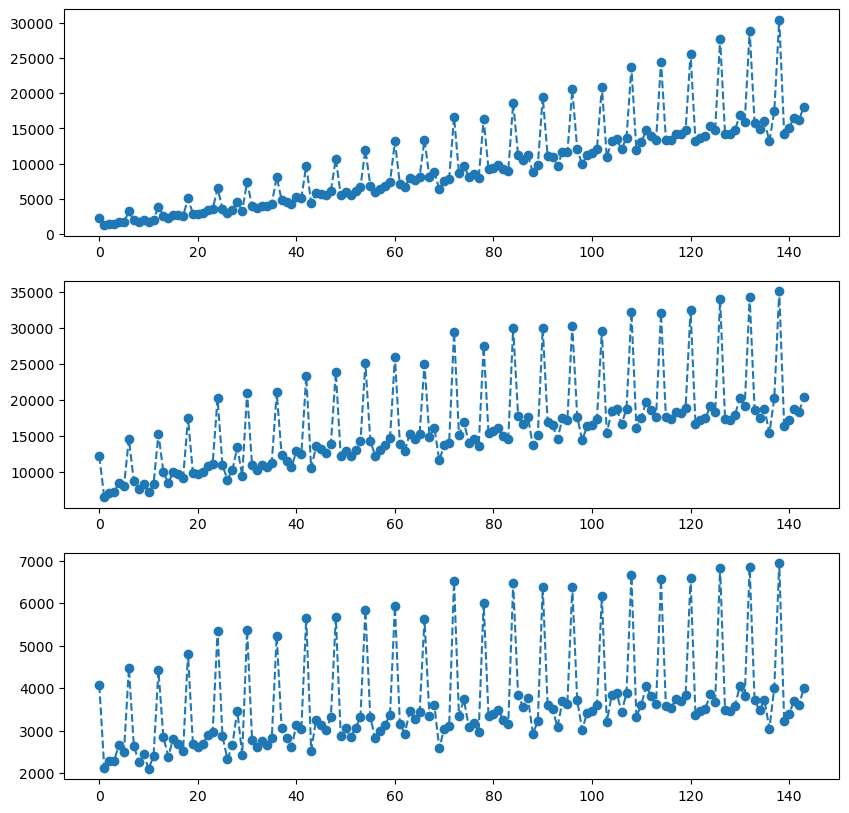

In [17]:
kg = 1e4
customer = "Dandy's Candies"
months = 144

amps = [1.5, 2, 1.2, 1.12, 1.32, 1.56, 1.89]
patterns = [[6,6], [4,8], [3,9], [2,10]]

amp = random.choice(amps)
pattern = random.choice(patterns)
print(pattern)

x = kg/(amp*pattern[0]+pattern[1])
X = amp * x
orders = [X + norm.rvs(1, scale=customers[customer]['std'])
if (i % (12/pattern[0]) == 0) else x
+ norm.rvs(1, scale=customers[customer]['std']) for i in range(months) ]

orders
fig, ax = plt.subplots(3, 1, figsize=(10,10))

if customers[customer]['shape'] == 'none':
    pass
elif customers[customer]['shape'] == 'linear':
    orders = (np.array(range(20,months+20)))*np.array(orders)/months*4
elif customers[customer]['shape'] == 'log':
    orders = (np.log(np.array(range(20,months+20))))*np.array(orders)
else:
    print('what?')
    
ax[0].plot((np.array(range(20,months+20)))*np.array(orders)/months*4, ls='--', marker='o')
ax[1].plot((np.log(np.array(range(20,months+20))))*np.array(orders), ls='--', marker='o')
ax[2].plot(np.array(orders), ls='--', marker='o')
plt.show()

In [18]:
from truffletopia import Truffle, UnitOperation, load_data

In [19]:
master = {}
index = 0
amps = [1.5, 2, 1.2, 1.12, 1.32, 1.56, 1.89]
patterns = [[6,6], [4,8], [3,9], [2,10]]

ind = 0
for customer in list(customers.keys()):
    amp = random.choice(amps)
    pattern = random.choice(patterns)
    for index in range(25):
#         customer = random.choice(list(customers.keys()))
        kg = random.randint(1e4, 1e5)
        months = 144
        

        orders = make_order(kg, customer, months, verbiose=False, pattern=pattern)
        truffle = Truffle()
        truffle.set_attributes()

        master[ind] = truffle.__dict__
        master[ind]['customer'] = customer
        a = {i: j for i,j in zip(dates,orders)}
        master[ind].update(a)
        ind += 1

## Process Generated Data

In [20]:
master = pd.DataFrame(master).T

In [21]:
master.dtypes

base_cake           object
truffle_type        object
primary_flavor      object
secondary_flavor    object
color_group         object
                     ...  
8/2021              object
9/2021              object
10/2021             object
11/2021             object
12/2021             object
Length: 150, dtype: object

In [22]:
master = master.melt(id_vars=master.columns[:6], var_name = 'date', value_name = 'kg')

In [23]:
process_data(master, pivot_dates=False)

,base_cake,truffle_type,primary_flavor,secondary_flavor,color_group,customer,date,kg
0,Butter,Chocolate Outer,Spice,Black Cherry,Tiffany,Slugworth,2010-01-01,10329.6
1,Tiramisu,Candy Outer,Spice,Rock and Rye,Taupe,Slugworth,2010-01-01,9710.54
2,Sponge,Jelly Filled,Wild Cherry Cream,Wild Cherry Cream,Slate,Slugworth,2010-01-01,8121.86
3,Sponge,Chocolate Outer,Fruit Punch,Pear,Teal,Slugworth,2010-01-01,1268.76
4,Pound,Chocolate Outer,Orange,Cucumber,Taupe,Slugworth,2010-01-01,4086.44
...,...,...,...,...,...,...,...,...
21595,Cheese,Jelly Filled,Watermelon,Pear,Teal,Bertie Bott,2021-12-01,29020.4
21596,Pound,Candy Outer,Butter Toffee,Mojito,Taupe,Bertie Bott,2021-12-01,29765.5
21597,Sponge,Chocolate Outer,Toasted Coconut,Mojito,Amethyst,Bertie Bott,2021-12-01,9984.77
21598,Sponge,Chocolate Outer,Coffee,Papaya,White,Bertie Bott,2021-12-01,24677.7


In [24]:
master.to_csv('data/12_year_orders.csv', index=False)

In [43]:
master.loc[master['date'] > datetime(2015, 12, 1)].reset_index(drop=True).to_csv('data/6_year_orders.csv', index=False)

# Analysis

## Feature Engineering

In [331]:
# boot data
df = pd.read_csv("data/12_year_orders.csv")
df = process_data(df)

In [332]:
X_train, X_test, qty, enc = train_test_split(df, groupby=None, verbiose=True)

(120, 132) (30, 132)


In [333]:
X, y, labels = sweep_window(X_train, qty, window=36, verbiose=True)

(11520, 36) (11520,)


## Train Model

### Parameterize Model

In [14]:
def CustomerForecaster(**kwargs):
    return make_pipeline(RandomForestRegressor(**kwargs))

param_grid = {
              'randomforestregressor__n_estimators': np.arange(10,50,10),
              'randomforestregressor__bootstrap': [True, False]
              }

grid = GridSearchCV(CustomerForecaster(), param_grid, cv=3)

params = []
for window in np.arange(12,12*12,12):
    params.append([X_train, qty, window, grid])

def parallel_search(X_train, qty, window, grid):
    X, y, labels = sweep_window(X_train, qty, window)
    grid.fit(X, y)
    
    # pull parameters from gridsearce results
    res = pd.DataFrame(grid.cv_results_).iloc[:,4:4+len(param_grid)]
    res['window'] = window
    res[pd.DataFrame(grid.cv_results_).iloc[:,-3:].columns] = pd.DataFrame(grid.cv_results_).iloc[:,-3:]
    
    return res

In [ ]:
pool = mp.Pool(mp.cpu_count())
results = [pool.apply_async(parallel_search, args=(param[0],
                                    param[1],
                                    param[2],
                                    param[3])) for param in params]
pool.close()
while True:
    if all([i.ready() for i in results]):
        res = []
        for i in results:
            try:
                a_result = i.get().copy()
                res.append(a_result)
            except:
                pass # search had failed

In [462]:
saved = {}
master = pd.DataFrame()
for window in np.arange(12,12*12,12)[:3]:
    X, y, labels = sweep_window(X_train, qty, window)
    grid.fit(X, y)
    res = pd.DataFrame(grid.cv_results_).iloc[:,4:4+len(param_grid)]
    res['window'] = window
    res[pd.DataFrame(grid.cv_results_).iloc[:,-3:].columns] = pd.DataFrame(grid.cv_results_).iloc[:,-3:]
    master = pd.concat([master, res])    
    ## OLD SUMMARY
    saved[window] = grid.best_params_
    saved[window]['best_score'] = grid.best_score_

In [472]:
results = pd.DataFrame(saved).T.sort_values('best_score', ascending=False)
results = results.reset_index()
results.columns = ['window', 'bootstrap', 'estimators', 'score']
display(results)
est = results.iloc[0]['estimators']
window = results.iloc[0]['window']
bootstrap = results.iloc[0]['bootstrap']

,window,bootstrap,estimators,score
0,36,True,40,0.996922
1,24,True,30,0.996846
2,12,True,40,0.996533


In [473]:
master = master.sort_values('mean_test_score', ascending=False).reset_index(drop=True)
master['rank_test_score'] = master.index + 1
master

,param_randomforestregressor__bootstrap,param_randomforestregressor__n_estimators,window,mean_test_score,std_test_score,rank_test_score
0,True,40,36,0.996922,0.000763,1
1,True,30,24,0.996846,0.000684,2
2,True,30,36,0.996842,0.000804,3
3,True,40,24,0.996823,0.000700,4
4,True,20,36,0.996773,0.000855,5
5,True,20,24,0.996739,0.000697,6
6,True,10,36,0.996641,0.000675,7
7,True,40,12,0.996533,0.000846,8
8,True,30,12,0.996530,0.000826,9
9,True,10,24,0.996437,0.000852,10


### Train with Tuned Hyperparameters

In [34]:
est = 40
window = 36
bootstrap = True

X_train, X_test, qty, enc = train_test_split(df, groupby=None, verbiose=True)
X, y, labels = sweep_window(X_train, qty, window)

model = RandomForestRegressor(n_estimators=est, bootstrap=bootstrap)
model.fit(X, y)

(120, 144) (30, 144)


RandomForestRegressor(n_estimators=40)

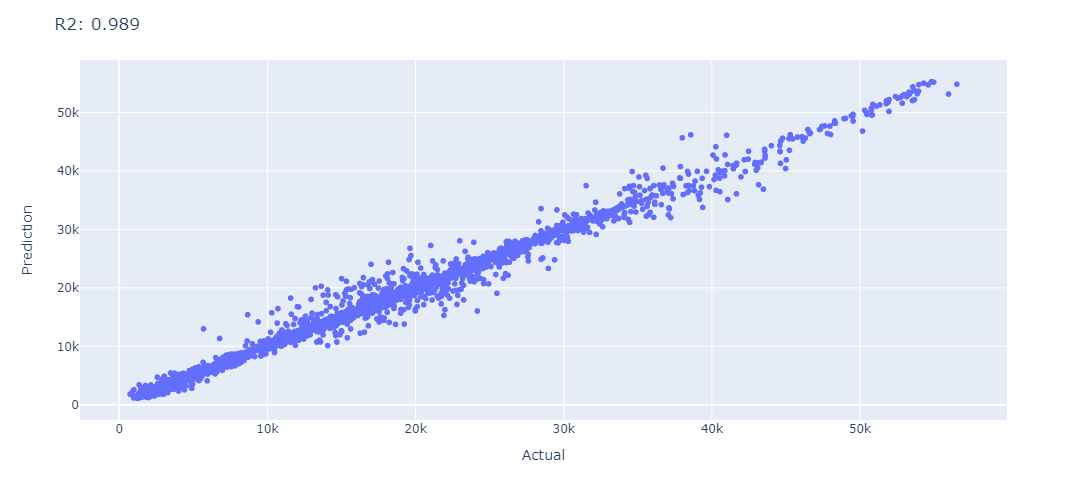

In [35]:
X_, y_, labels = sweep_window(X_test, qty, window=window)
pred = model.predict(X_)
fig = px.scatter(x=y_, y=pred, hover_name=labels,
                 labels={
                     "y": "Prediction",
                     "x": "Actual"
                 })
fig.update_layout(
  autosize=False,
  width=800,
  height=500,
  title='R2: {:.3f}'.format(r2_score(y_, pred))
  )

In [36]:
joblib.dump(model, "data/customer_forcast.joblib")

['data/customer_forcast.joblib']

## Implement Model

### Single Month Forecasting

In [37]:
model = joblib.load("data/customer_forcast.joblib")

In [38]:
# boot data
df = pd.read_csv("data/12_year_orders.csv")
df = process_data(df)

(1, 144) (1, 144)
(108, 36) (108,)


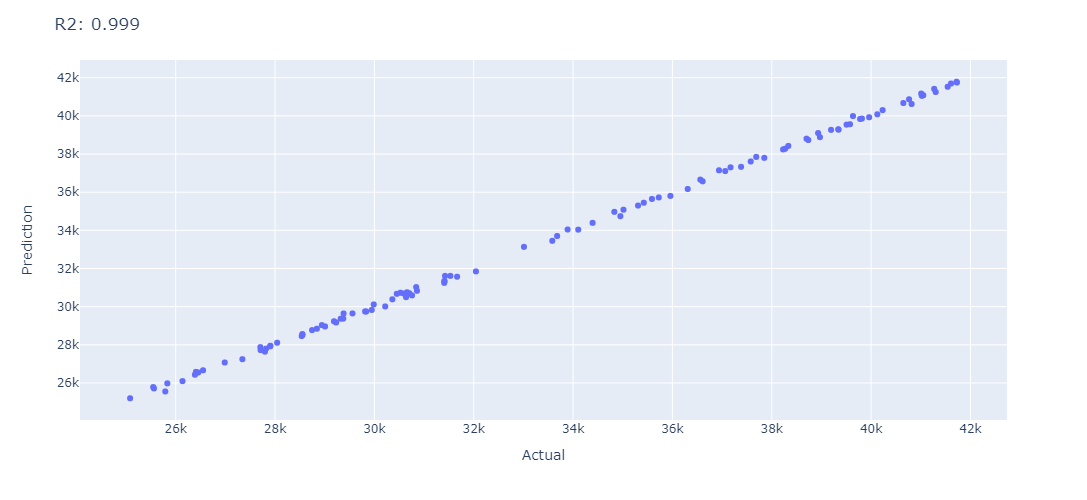

In [39]:
groupby = 'primary_flavor'
item = 'Doughnut'
trace_color = 'base_cake'

# prep data
if groupby:
    dff = df.loc[df[groupby] == item].copy()
else:
    dff = df.copy()
X_train, X_test, qty, enc = train_test_split(dff, groupby=None, verbiose=True)
X, y, labels = sweep_window(X_train, qty, window=36, verbiose=True)

# predict
pred = model.predict(X)

# prep for plotting
# color = df.loc[df[groupby] == item][trace_color].values
dff = pd.DataFrame([pred,y]).T
dff.columns = ['Prediction', 'Actual']


fig = px.scatter(dff, x='Actual', y='Prediction')
fig.update_layout(
  autosize=False,
  width=800,
  height=500,
  title='R2: {:.3f}'.format(r2_score(y, pred))
  )

### Extrapolated Forecasting

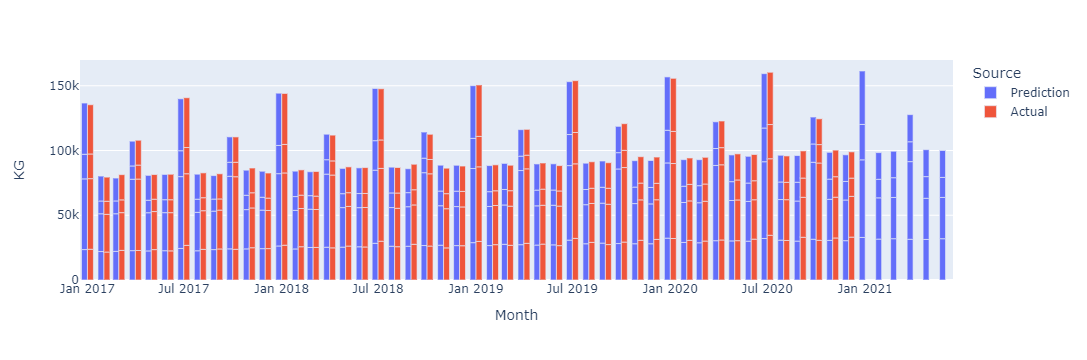

In [343]:
dff = make_forcast(model, df, window=36, qty=qty, projection=6, groupby='primary_flavor', item='Ginger Lime', time_delta_previous=48)
px.bar(dff, x='Month', y='KG', color='Source', barmode='group')

### load, predict

(120, 144) (30, 144)


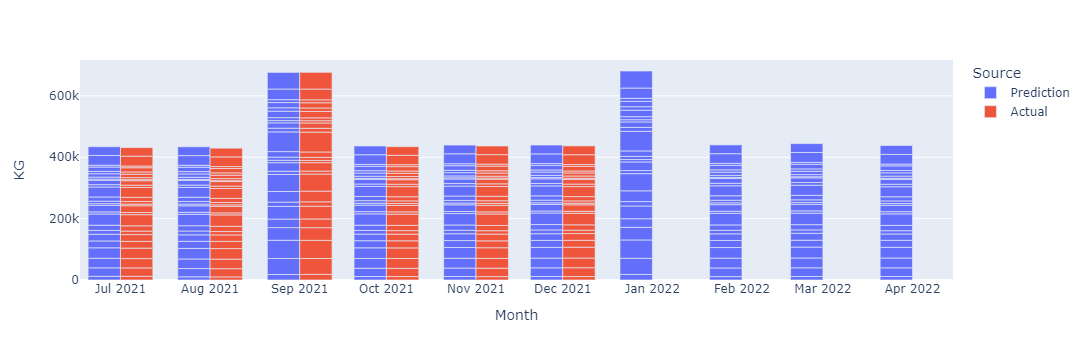

In [48]:
#data
df = pd.read_csv("data/12_year_orders.csv")
df = process_data(df)
X_train, X_test, qty, enc = train_test_split(df, groupby=None, verbiose=True)

# model
model = joblib.load("data/customer_forcast.joblib")
dff = make_forcast(model, df, window=36, qty=qty, projection=4, groupby='customer', item='Perk-a-Cola', time_delta_previous=6)

# plot
px.bar(dff, x='Month', y='KG', color='Source', barmode='group')

# Customer Analytics

In [122]:
from plotly.subplots import make_subplots

In [49]:
#data
df = pd.read_csv("data/12_year_orders.csv")
df = process_data(df, pivot_dates=False)
print(df.dtypes)

base_cake                   object
truffle_type                object
primary_flavor              object
secondary_flavor            object
color_group                 object
customer                    object
date                datetime64[ns]
kg                         float64
dtype: object


In [55]:
master['date'] = pd.to_datetime(master['date'])
master['kg'] = pd.to_numeric(master['kg'])
master.head()

,base_cake,truffle_type,primary_flavor,secondary_flavor,color_group,customer,date,kg,year,month
0,Butter,Chocolate Outer,Spice,Black Cherry,Tiffany,Slugworth,2010-01-01,10329.597624,2010,1
1,Tiramisu,Candy Outer,Spice,Rock and Rye,Taupe,Slugworth,2010-01-01,9710.539638,2010,1
2,Sponge,Jelly Filled,Wild Cherry Cream,Wild Cherry Cream,Slate,Slugworth,2010-01-01,8121.859036,2010,1
3,Sponge,Chocolate Outer,Fruit Punch,Pear,Teal,Slugworth,2010-01-01,1268.760063,2010,1
4,Pound,Chocolate Outer,Orange,Cucumber,Taupe,Slugworth,2010-01-01,4086.442367,2010,1


In [58]:
master[master.columns[:-2]]

,base_cake,truffle_type,primary_flavor,secondary_flavor,color_group,customer,date,kg
0,Butter,Chocolate Outer,Spice,Black Cherry,Tiffany,Slugworth,2010-01-01,10329.597624
1,Tiramisu,Candy Outer,Spice,Rock and Rye,Taupe,Slugworth,2010-01-01,9710.539638
2,Sponge,Jelly Filled,Wild Cherry Cream,Wild Cherry Cream,Slate,Slugworth,2010-01-01,8121.859036
3,Sponge,Chocolate Outer,Fruit Punch,Pear,Teal,Slugworth,2010-01-01,1268.760063
4,Pound,Chocolate Outer,Orange,Cucumber,Taupe,Slugworth,2010-01-01,4086.442367
...,...,...,...,...,...,...,...,...
21595,Cheese,Jelly Filled,Watermelon,Pear,Teal,Bertie Bott,2021-12-01,29020.381420
21596,Pound,Candy Outer,Butter Toffee,Mojito,Taupe,Bertie Bott,2021-12-01,29765.474672
21597,Sponge,Chocolate Outer,Toasted Coconut,Mojito,Amethyst,Bertie Bott,2021-12-01,9984.768568
21598,Sponge,Chocolate Outer,Coffee,Papaya,White,Bertie Bott,2021-12-01,24677.656848


In [51]:
df = process_data(master, pivot_dates=False)

In [52]:
df['year'] = df['date'].apply(lambda x: x.year)
df['month'] = df['date'].apply(lambda x: x.month)

In [53]:
def make_seasonal_plot(df):
    fig1 = px.line(df, x='month', y='kg', color='year')
    fig1.update_traces(line=dict(color = 'rgba(50,50,50,0.2)'))
    fig2 = px.scatter(df, x='month', y='kg', color='year', color_continuous_scale='viridis')
    fig3 = go.Figure(data=fig1.data + fig2.data)
    fig3.update_layout({'title': customer,
                        'showlegend': False})
    return fig3

# Dashboard Prototype

In [309]:
for trace in fig['data']:
    trace['showlegend'] = False

In [54]:
from dash import dcc, html, Dash, Input, Output
from datetime import date
from jupyter_dash import JupyterDash
import dash_bootstrap_components as dbc

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css',
                        dbc.themes.VAPOR # SLATE,VAPOR
                        ]


app = JupyterDash(__name__, external_stylesheets=external_stylesheets,prevent_initial_callbacks=True)
style = {'height': 100,
         'fontsize': 6}

plot_layouts = {
    "template": "plotly_dark",
    "height": style['height'],
    "margin": dict(
        l=0,
        r=0,
        b=0,
        t=30,
        pad=4
    ),
    "font": (dict(size=style['fontsize']))}

# Create server variable with Flask server object for use with gunicorn
server = app.server

app.layout = html.Div([
    dbc.Button('start', id='start'),
    html.Div(id='plots', className='twelve columns')
])

@app.callback(Output('plots', 'children'),
             Input('start', 'n_clicks'))
             
def populate(click):
    figs = []
    for customer in df.customer.unique():
        dff = df.loc[df['customer'] == customer].groupby(['year', 'month'])[['kg']].sum().reset_index()
        fig = make_seasonal_plot(dff)
        for trace in fig['data']: 
            trace['showlegend'] = False
        fig.update_layout(plot_layouts, showlegend=False,title=customer)
        figs.append(fig)
    div = html.Div([
        html.H1("YoY Customer Profiles"),
        dbc.Row([
            dbc.Col([
                dcc.Graph(
                    figure=figs[0],
                ),
            ]),
            dbc.Col([
                dcc.Graph(
                    figure=figs[1],
                ),
            ]),
        ], className="twelve columns",),
        dbc.Row([
            dbc.Col([
                dcc.Graph(
                    figure=figs[2],
                ),
            ]),
            dbc.Col([
                dcc.Graph(
                    figure=figs[3],
                ),
            ]),
        ], className="twelve columns",),
        dbc.Row([
            dbc.Col([
                dcc.Graph(
                    figure=figs[4],
                ),
            ]),
            dbc.Col([
                dcc.Graph(
                    figure=figs[5],
                ),
            ]),
        ], className="twelve columns",),
    ])
    return div

app.run_server(mode="inline")